In [1]:
import numpy as np
import math 

In [2]:
def f(x):
    return (5*x + 1)/(13*(2*x + 3))

assert f(-0.2) == 0
assert f(1) == 6/65

In [3]:
def build_newton_forward(data):
    """
    :params:
        data: np.array (2,)
    :returns: polynome as a function of x
    """
    L = data.shape[0]
    h = data[1][0] - data[0][0]
    diffs = np.zeros((L, L))
    diffs[0] = data.T[1]
    #print(diffs)
    
    for i in range(1, L+1):
        for j in range(L - i):
            diffs[i][j] = diffs[i-1][j+1] - diffs[i-1][j]
            
    def polynome(x):
        
        res = data[0][1]
        q = (x - data[0,0])/h
        
        for i in range(1, L):
            summ = diffs[i][0]/(math.factorial(i) )
            for j in range(i):
                summ *= (q - j)
            res += summ
        return res
    return polynome
        

In [4]:
def build_newton_backward(data):
    """
    functor to generate special type of polynomial
    :params:
        data: np.array (2,)
    :returns: polynome as a function of x
    """
    L = data.shape[0]
    h = data[1][0] - data[0][0]
    diffs = np.zeros((L, L))
    diffs[0] = data.T[1]
    #print(diffs)
    
    for i in range(1, L+1):
        for j in range(L - i):
            diffs[i][j] = diffs[i-1][j+1] - diffs[i-1][j]
            
    def polynome2(x):
        
        res = data[-1][1]
        q = (x - data[-1][0])/h
        
        for i in range(L-1):
            summ = diffs[i+1][-(i+2)]/(math.factorial(i+1) )
            for j in range(i+1):
                summ *= (q + j)
            res += summ
        return res
    return polynome2
    

In [5]:
def build_lagrange_poly(data):
    """
    functor to generate lagrangian polynomial for interpolation
    """
    
    def poly(x):
        res = 0
        for i in range(data.shape[0]):
            sumo = data[i][1]
            for j in range(data.shape[0]):
                if i != j:
                    sumo *= (x - data[j][0])/(data[i][0] - data[j][0])
            res += sumo
        return res
    return poly

In [6]:
def spline(data, x):
    
    L = data.shape[0]
    splines = np.zeros((L, 4))
    
    for i in range(L):
        splines[i][0] = f(data[i][0])
        
    alpha = np.zeros(L - 1)
    beta = np.zeros(L - 1)
    
    for i in range(1, L - 1):
        h_i = data[i][0] - data[i-1][0]
        h_ii = data[i+1][0] - data[i][0]
        A = h_i
        C = 2*(h_i + h_ii)
        B = h_ii
        
        F = 6 * ( ( f(data[i+1][0]) - f(data[i][0]) )/h_ii - ( f(data[i][0]) - f(data[i-1][0]) )/h_i)
        z = (A * alpha[i-1] + C)
        alpha[i] = -B/z
        beta[i]  = (F - A*beta[i-1])/z
    
    splines[-1][2] = (F - A*beta[L-2])/(C + A*alpha[L-2])
    
    for i in range(L - 2, 0, -1):
        splines[i][2] = alpha[i] * splines[i+1][2] + beta[i]
        
    for i in range(L - 1, 0, -1):
        h_i = data[i][0] - data[i-1][0]
        splines[i][3] = (splines[i][2] - splines[i-1][2])/6 + ( f(data[i][0]) - f(data[i-1][0]) )/h_i
    
    if (x < data[0][0]):
        s = splines[0]
        p = data[0][0]
    elif x > data[-1][0]:
        s = splines[-1]
        p = data[-1][0]
    else:
        i = 0
        j = L-1
        
        while (i + 1 < j):
            k = i + math.floor((j-i)/2)
            if (x < data[k][0]):
                j = k
            else:
                i = k
        s = splines[j]
        p = data[j][0]
    dx = x - p
    return s[0] + s[1]*dx + s[2]*dx*dx/2 + s[3]*dx*dx*dx/6
        

In [7]:
if __name__ == "__main__":
    # First NewTon Polynome
    A=-1
    B=10
    N = 5
    points = np.zeros((N, 2))
    for i in range(N):
        points[i] = [A + i*(B-A)/(N-1), f(A + i*(B-A)/(N-1))]
    
    NF = build_newton_forward(points)
    NB = build_newton_backward(points)
    LG = build_lagrange_poly(points)
    
    
    #for i in range(A, B):
        #print(i, func(i))

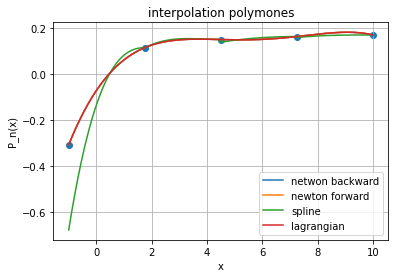

In [11]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
t = np.arange(A, B, 0.001)
tf = np.zeros(t.shape)

nb = np.zeros(t.shape)
nf = np.zeros(t.shape)
lg = np.zeros(t.shape)
sp = np.zeros(t.shape)

for i in range(t.shape[0]):
    tf[i] = f(t[i])

for i in range(t.shape[0]):
    nb[i] = NB(t[i])

for i in range(t.shape[0]):
    nf[i] = NF(t[i])

for i in range(t.shape[0]):
    lg[i] = LG(t[i])
    
for i in range(t.shape[0]):
    sp[i] = spline(points, t[i])
    
# for i in range(s.shape[0]):
#     res = abs(f(t[i]) - func(t[i]))
#     s[i] = res

fig, ax = plt.subplots()
ax.plot(t, nb)
ax.plot(t, nf)
ax.plot(t, sp)
ax.plot(t, lg)

ax.legend(["netwon backward", "newton forward", "spline", "lagrangian"])
ax.scatter(points.T[0], points.T[1])

ax.set(xlabel='x', ylabel='P_n(x)',
       title='interpolation polymones')
ax.grid()

fig.savefig("interpolation.png")
plt.show()